### [Gold Price Prediction using Machine Learning](https://www.geeksforgeeks.org/gold-price-prediction-using-machine-learning/)

In [1]:
!pip install -U seaborn xgboost eli5


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV

In [3]:
# read dataset using pndas function
# use parse_dates argument to change datetime dtype
dataset = pd.read_csv("data/gold_price_data.csv", parse_dates=["Date"])

#df = pd.DataFrame(columns=['Date'],dtype='datetime64[ns]')
dataset = dataset.astype({'Date':'datetime64[ns]'})

In [4]:
# information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [5]:
# Missing Values/Null Values Count
dataset.isna().sum().sort_values(ascending=False)

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

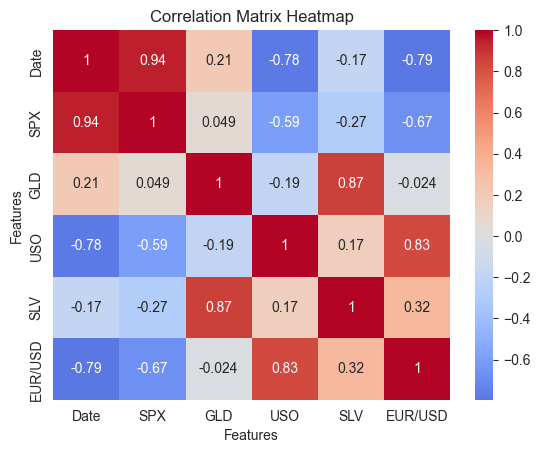

In [6]:
# Calculate correlation matrix
correlation  = dataset.corr()
 
# Create heatmap
sns.heatmap(correlation, cmap='coolwarm', center=0, annot=True)
 
# Set title and axis labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
 
# Show plot
plt.show()

In [7]:
# drop SlV column
dataset.drop("SLV", axis=1, inplace=True)

In [8]:
# reset the index to date column
dataset.set_index("Date", inplace=True)

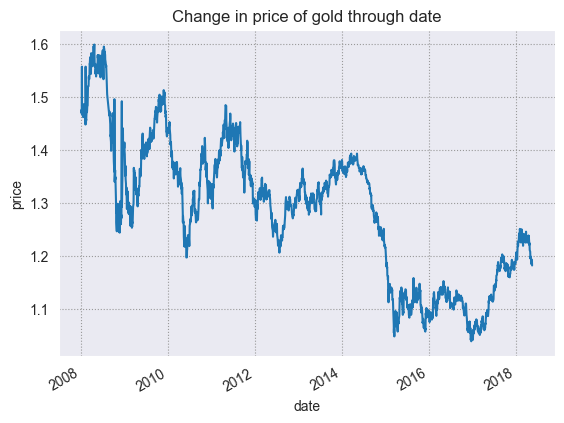

In [9]:
# plot price of gold for each increasing day
dataset["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

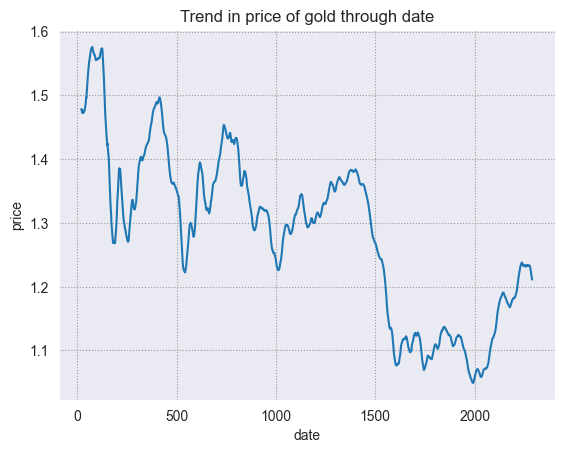

In [10]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"].rolling(window=20).mean()
 
# reset the index to date column
dataset.reset_index("Date", inplace=True)
 
# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()
 
# set title of the chart
plt.title("Trend in price of gold through date")
 
# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()

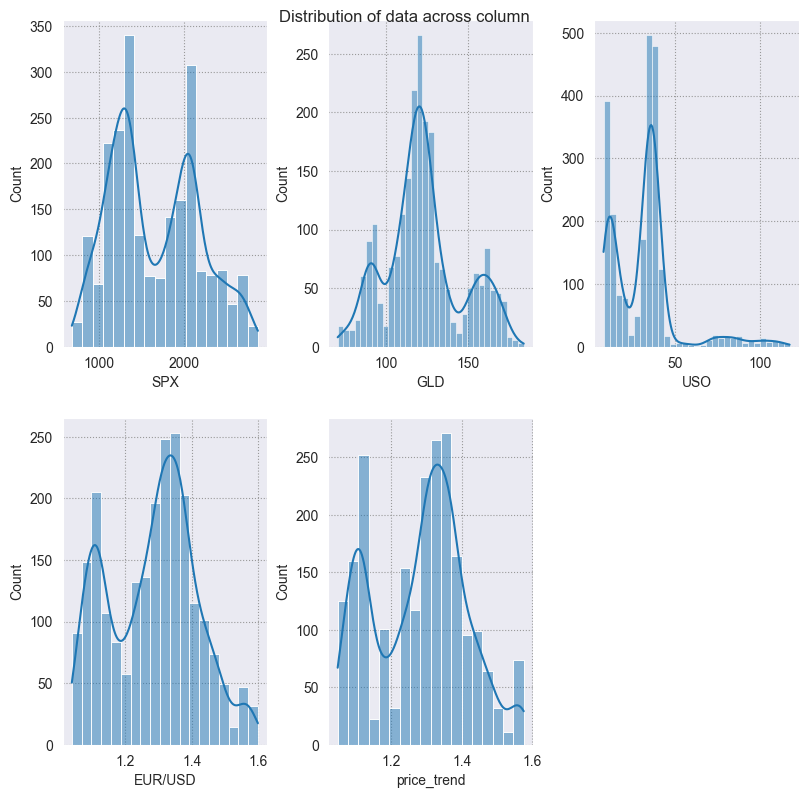

In [11]:
fig = plt.figure(figsize=(8, 8))
 
# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=dataset, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [12]:
# skewness along the index axis
temp_ds = dataset.drop("Date", axis=1)
print(temp_ds.skew(axis=0, skipna=True))

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [13]:
# apply saquare root transformation
# on the skewed dataset
dataset["USO"] = dataset["USO"].apply(lambda x: np.sqrt(x))

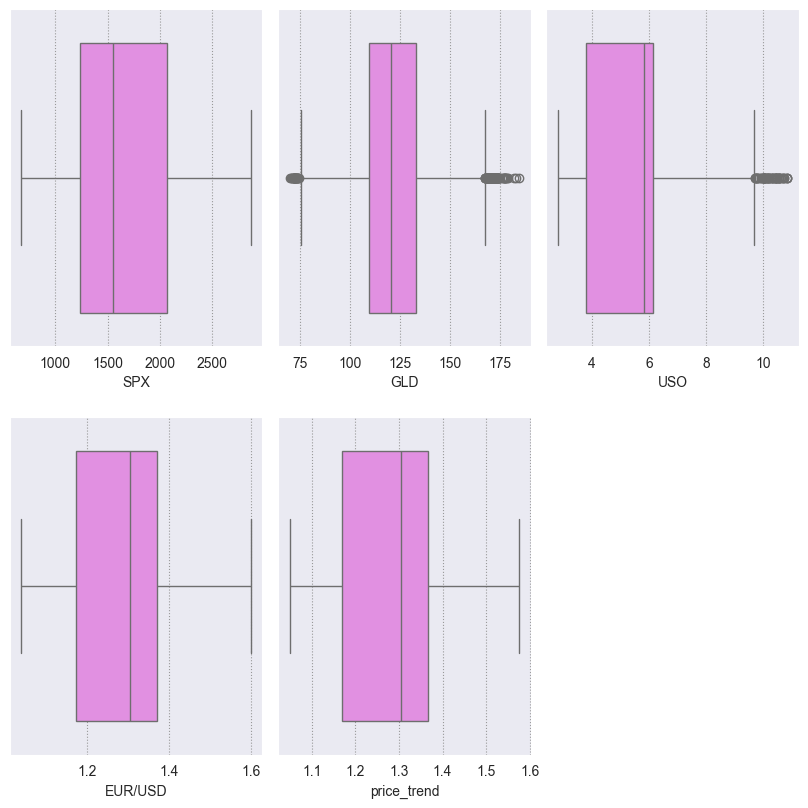

In [14]:
fig = plt.figure(figsize=(8, 8))
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [15]:
def outlier_removal(column):
    # Capping the outlier rows with Percentiles
    upper_limit = column.quantile(.95)
    # set upper limit to 95percentile
    lower_limit = column.quantile(.05)
    # set lower limit to 5 percentile
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column

In [16]:
# Normalize outliers in columns except Date
dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

In [17]:
# select the features and target variable
X = dataset.drop(['Date', 'EUR/USD'], axis=1)
 
y = dataset['EUR/USD']
# dividing dataset in to train test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
# Create an instance of the StandardScaler
scaler = StandardScaler()
 
# Fit the StandardScaler on the training dataset
scaler.fit(x_train)
 
# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [19]:
## View the scaled value of x_train
x_train_scaled

array([[-0.09810498,  0.57831547,  0.2864341 ,  0.14128161],
       [ 1.85468587,  0.13546997, -1.18619382, -0.37325647],
       [ 1.85468587,  0.09446571, -1.23273658, -0.36410812],
       ...,
       [ 0.89910006, -0.34154571, -0.62265241, -1.56130102],
       [ 1.29587255, -0.2522477 , -1.32968139, -1.62445976],
       [ 0.07879206,  0.16508384,  0.56015777,  0.37259752]])

In [20]:
## View the scaled value of x_test
x_test_scaled

array([[ 0.24829021, -0.12467928,  0.37539106,  0.62489471],
       [ 0.28480652, -0.23903519,  0.31089586,  0.52294599],
       [-1.51423243, -1.48601888, -0.10419789,  0.15690414],
       ...,
       [-1.03583943, -0.54747814,  0.65406882,  0.62818129],
       [-0.55271281, -1.58716264,  2.14905976,         nan],
       [ 1.22184276, -0.54519999, -1.30679337, -1.7621734 ]])

In [21]:
## View the values of y_train
y_train

1193    1.309329
2267    1.225160
2253    1.237562
686     1.349856
1265    1.352174
          ...   
1318    1.366662
776     1.417294
1616    1.087796
2011    1.073975
1249    1.333796
Name: EUR/USD, Length: 1832, dtype: float64

In [22]:
## View the values of y_test
y_test

1337    1.355877
1296    1.358511
235     1.291406
1368    1.392661
471     1.356208
          ...   
2164    1.165175
2255    1.228079
475     1.362899
9       1.480210
1986    1.073975
Name: EUR/USD, Length: 458, dtype: float64

In [23]:
## Check for NaN/Null in y-test set
y_test.isna().sum()

np.int64(0)

In [24]:
## Check for NaN/Null in y-train set
y_train.isna().sum()

np.int64(0)

In [25]:
# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)
 
# Create a Lasso object
lasso = Lasso()
 
# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
                               1e-1, 1, 5, 10, 
                               20, 30, 40]}
 
# Create a pipeline that first applies 
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)
 
# Create a GridSearchCV object with 
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=3)
 
# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train.dropna())
 
# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled.dropna())
 
# Compute the R-squared of the fitted model on the train  data
r2 = r2_score(y_train.dropna(), y_pred)
 
# Print the R-squared
print("R-squared: ", r2)
 
# Print the best parameter values and score
print('Best parameter values: ', lasso_grid_search.best_params_)
print('Best score: ', lasso_grid_search.best_score_)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\preprocessing\_polynomial.py", line 323, in fit
    _, n_features = self._validate_data(X, accept_sparse=True).shape
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\utils\validation.py", line 1064, in check_array
    _assert_all_finite(
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\utils\validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\utils\validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


#### RandomForestRegressor for Regression

In [26]:
# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [3, 5, 7]}
 
# create instance of the Randomforest regressor
rf = RandomForestRegressor()
 
# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)
 
# Fit the GridSearchCV object to the training data
 
rf_grid_search.fit(x_train_scaled, y_train)
 
# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 100}
Best score:  0.9745830566296435


In [27]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test, rf_grid_search.predict(x_test_scaled))
 
# Print the R-squared
print("R-squared:", r2)

R-squared: 0.9824039617970401


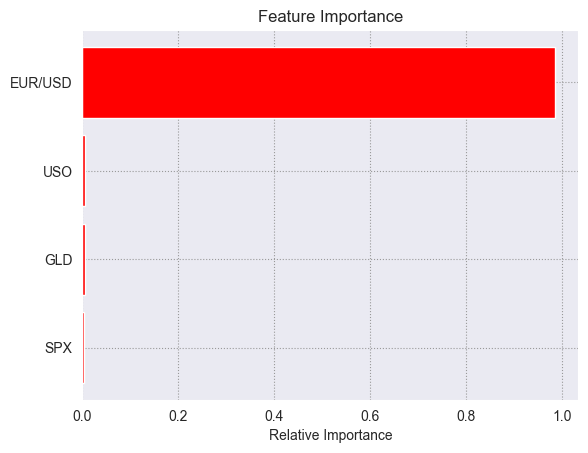

In [28]:
features = dataset.drop("Date", axis=1).columns
 
# store the importance of the feature
importances = rf_grid_search.best_estimator_.feature_importances_

indices = np.argsort(importances)
 
# title of the graph
plt.title('Feature Importance')
 
plt.barh(range(len(indices)),
         importances[indices],
         color='red', align='center')
 
# plot bar chart
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### XGBoost Model for Regression

In [29]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()
 
# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)
 
# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9995549811832775


In [30]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =", r2_score(y_test, model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9846172527752205


In [31]:
import eli5
# weight of variables in xgboost model
# Get the names of the features
feature_names = x_train.columns.tolist()
 
# Explain the weights of the features using ELI5
eli5.explain_weights(model_xgb, feature_names=feature_names)

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (D:\WORKSPACE\GitHub\shortthirdman\DataScience-Jupyter-Notebooks\dev\Lib\site-packages\sklearn\utils\metaestimators.py)

#### Model Deployment using Pickle

In [ ]:


# dump model using pickle library
import pickle
 
# dump model in file model.pkl
pickle.dump(model_xgb, open('model.pkl', 'wb'))